In [47]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("simulator.jl")
using .simulator, Plots, Statistics, Distributions, KernelDensity, StatsBase

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics

$$ 
\begin{align}
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{more Biomass X}, \\
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{Product Y}, \\
    \text{Product Y} &\xrightarrow{\text{Biomass X}} \text{Byproduct Z}.
\end{align}
$$

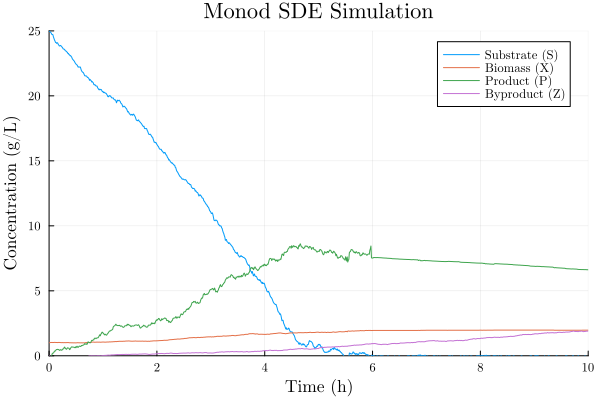

In [48]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params  = Dict(
    "μ_max" => 0.244, 
    "K_sx" => 11.5, 
    "Y_xs" => 0.28,
    "Y_ys" => 0.42,
    "m_s" => 0.015,
    "q_max_y" => 1.79,
    "K_sy" => 1.68,
    "q_max_z" => 0.11,
    "K_sz" => 0.15,
    "σs" => 0.5, 
    "K_σs" => 0.1,
    "σx" => 0.05, 
    "K_σx" => 0.1,
    "σy" => 0.5,
    "K_σy" => 0.1, 
    "σz" => 0.05,
    "K_σz" => 0.1
)

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "S0" => 25.0, 
    "X0" => 1.0, 
    "Y0" => 0, 
    "Z0" => 0
)

# Time parameters
tspan = (0.0, 10.0)  # Time span for the simulation
dt = 0.01  # Time step for the simulation
N = Int((tspan[2] - tspan[1]) / dt)  # Number of time steps
tsteps = tspan[1]:dt:tspan[2]  # Time steps array

# Running the Monte Carlo simulation
M = 10_000  # Number of Monte Carlo simulations
sol = simulate_paths(params, tspan, init, M, dt)

# Storing the results in matrices for each state variable
S = zeros(length(sol), length(sol[1].t))
X = zeros(length(sol), length(sol[1].t))
Y = zeros(length(sol), length(sol[1].t))
Z = zeros(length(sol), length(sol[1].t))

for i in 1:length(sol)
    S[i, :] = sol[i][1, :]
    X[i, :] = sol[i][2, :]
    Y[i, :] = sol[i][3, :]
    Z[i, :] = sol[i][4, :]
end

# Plotting the results
plot(sol[53], title="Monod SDE Simulation", label=["Substrate (S)" "Biomass (X)" "Product (P)" "Byproduct (Z)"], xlabel="Time (h)", ylabel="Concentration (g/L)")
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["S0"]), xlims=(0, 10))

### Longstaff-Schwartz Algorithm

In [49]:
# Initialize matrices for Longstaff-Schwartz
V = copy(Y) # copy(X) if we're using X
degree = 3  # Degree of polynomial basis
β_matrix = zeros(N, degree + 1)
τ = fill(length(tsteps), M)

# Longstaff-Schwartz backward induction in time
for n in (length(tsteps)-1):-1:2
    y_now = Y[:, n]
    value_future = V[:, n+1]

    # Optional: Filter out non-positive values (in-the-money paths for options)
    # all of the values are supposed to be positive
    itm_indices = findall(y -> y > 0, y_now)
    if length(itm_indices) < 10
        continue
    end

    y_itm = y_now[itm_indices]
    vf_itm = value_future[itm_indices]

    # Fit polynomial regression using Laguerre basis functions
    Φ = laguerre_design_matrix(y_itm, degree)
    β = Φ \ vf_itm
    
    # Compute continuation value
    # Note: This is where the polynomial regression is used to compute the continuation value
    continuation_value = Φ * β
    stop_now = y_itm .> continuation_value

    # Update stopping times
    # Note: This is where we update the stopping times based on the stopping condition
    for (idx, stop) in zip(itm_indices, stop_now)
        if stop
            V[idx,n] = y_now[idx]
            τ[idx] = min(τ[idx], n)
        else
            V[idx,n] = V[idx,n+1]
        end
    end

    # Save regression coefficients
    β_matrix[n, :] .= β

end

# Compile outputs
Y_opt_values = [Y[i, τ[i]] for i in 1:M];
τ_times = [tsteps[τ[i]] for i in 1:M];

### Results

In [50]:
# Plotting the results
println("Estimated optimal expected value of Y: ", round(mean(Y_opt_values), digits=4), " g/L")
println("Expected optimal stopping time: ", round(mean(τ_times), digits=4), " h")
println("95% confidence interval for stopping time: ", round(quantile(τ_times, 0.025), digits=4), " to ", round(quantile(τ_times, 0.975), digits=4), " h")
println("95% confidence interval for expected value of Y: ", round(quantile(Y_opt_values, 0.025), digits=4), " to ", round(quantile(Y_opt_values, 0.975), digits=4))

Estimated optimal expected value of Y: 8.8902 g/L
Expected optimal stopping time: 7.8082 h
95% confidence interval for stopping time: 4.3298 to 9.22 h
95% confidence interval for expected value of Y: 3.8764 to 15.0782
